# Learning PyTorch

Learning PyTorch is a series of notebooks I created to learn PyTorch.

Source: https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html

**Neural networks** can be constructed using the [`torch.nn` package](https://pytorch.org/docs/stable/nn.html#torch-nn).

`nn` depends on `autograd` to define models and differentiate them. An `nn.Module` contains layers, and a method `forward(input)` that returns the `output`.

**Convolutional Neural Network (convnet)** is a simple feed-forward network. It takes the input, feeds it through several layers one after the other, and then finally gives the output.

A typical training procedure for a neural network is as follows:

- Define the neural network that has some learnable parameters (or weights)
- Iterate over a dataset of inputs
- Process input through the network
- Compute the loss (how far is the output from being correct)
- Propagate gradients back into the network’s parameters
- Update the weights of the network, typically using a simple update rule: `weight = weight - learning_rate * gradient`

## Define the Network

Let's define the following network as below.

We have a `forward` function, and the `backward` function (where gradients are computed) is automatically defined for us using `autograd`. We can use any of the Tensor operations in the `forward` function.

The learnable parameters of a model are returned by `net.parameters()`.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MyNet(nn.Module):

    def __init__(self):
        super(MyNet, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension (i.e. start_dim = 1).
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [2]:
net = MyNet()
print(net)

MyNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


`nn.Parameter` is a kind of Tensor, that is automatically registered as a parameter when assigned as an attribute to a `Module`.

In [3]:
params = list(net.parameters())
print(len(params))

print(params[0].size())  # conv1's .weight

10
torch.Size([6, 1, 5, 5])


In [4]:
for i in range(len(params)):
    print(params[i].size())

torch.Size([6, 1, 5, 5])
torch.Size([6])
torch.Size([16, 6, 5, 5])
torch.Size([16])
torch.Size([120, 400])
torch.Size([120])
torch.Size([84, 120])
torch.Size([84])
torch.Size([10, 84])
torch.Size([10])


In [5]:
# Try a random 32x32 input

input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor([[-0.0459,  0.0954, -0.0344, -0.0545, -0.0928, -0.1139,  0.0577,  0.0809,
         -0.0388,  0.0445]], grad_fn=<AddmmBackward>)


**Note:** `torch.nn` only supports mini-batches. The entire `torch.nn` package only supports inputs that are a mini-batch of samples, and not a single sample.

For example, `nn.Conv2d` will take in a 4D Tensor of `nSamples x nChannels x Height x Width`.

If you have a single sample, just use `input.unsqueeze(0)` to add a fake batch dimension.

In [6]:
# Zero the gradient buffers of all parameters and backprops with random gradients.

net.zero_grad()
bk = out.backward(torch.randn(1, 10))

In [7]:
print(bk)

None


## Loss Function

A loss function takes the (output, target) pair of inputs, and computes a value that estimates how far away the output is from the target.

There are several different [loss functions under the nn package](https://pytorch.org/docs/stable/nn.html#loss-functions) . A simple loss is: `nn.MSELoss` which computes the mean-squared error between the input and the target.

In [8]:
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target

tensor([ 0.5090, -0.0825,  0.9759, -1.3555,  0.3941, -0.7330,  1.1685, -1.7318,
         1.6088, -0.0488])

In [9]:
target = target.view(1, -1)  # make it the same shape as output
target

tensor([[ 0.5090, -0.0825,  0.9759, -1.3555,  0.3941, -0.7330,  1.1685, -1.7318,
          1.6088, -0.0488]])

In [10]:
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(1.0917, grad_fn=<MseLossBackward>)


Now, if you follow loss in the backward direction, using its `.grad_fn` attribute, you will see a graph of computations that looks like this:

> input -> conv2d -> relu -> maxpool2d -> conv2d -> relu -> maxpool2d
>
>         -> flatten -> linear -> relu -> linear -> relu -> linear
>
>         -> MSELoss
>
>         -> loss

So, when we call `loss.backward()`, the whole graph is differentiated w.r.t. the neural net parameters, and all Tensors in the graph that have `requires_grad=True` will have their `.grad` Tensor accumulated with the gradient.

For illustration, let us follow a few steps backward:

In [11]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

## Backprop

To backpropagate the error all we have to do is to `loss.backward()`. You need to clear the existing gradients though, else gradients will be accumulated to existing gradients.

Now we shall call `loss.backward()`, and have a look at conv1’s bias gradients before and after the backward.

In [12]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([-0.0006,  0.0024,  0.0083,  0.0038,  0.0056, -0.0045])


## Update the weights

The simplest update rule used in practice is the Stochastic Gradient Descent (SGD):

`weight = weight - learning_rate * gradient`

In [13]:
# We can implement this using simple Python code:

learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)

As we're using neural networks, we want to use various different update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc. To enable this, we have a small package: `torch.optim` that implements all these methods.

Observe how gradient buffers had to be manually set to zero using `optimizer.zero_grad()`. This is because gradients are accumulated as explained in the Backprop section.

In [14]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()            # zero the gradient buffers
output = net(input)
loss = criterion(output, target) # criterion = nn.MSELoss()
loss.backward()
optimizer.step()                 # Does the update

# Example: Training an image classifier

Here, we will use the CIFAR10 dataset. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

In [15]:
import torch
import torchvision
import torchvision.transforms as transforms

### 1. Load and normalize CIFAR10

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

**Note:** `ToTensor()` converts a PIL image or NumPy `ndarray` into a `FloatTensor`, and scales the image’s pixel intensity values in the range [0., 1.]

In [16]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

0it [00:00, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


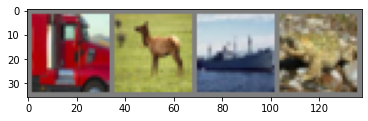

truck  deer  ship  frog


In [17]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

### 2. Define a Convolutional Neural Network

In [18]:
import torch.nn as nn
import torch.nn.functional as F

class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch (i.e. start_dim = 1).
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [19]:
net = MyNet()
net

MyNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### 3. Define a [Loss Function](https://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](https://pytorch.org/docs/stable/optim.html)

In [20]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Train the network

We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [21]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.168
[1,  4000] loss: 1.844
[1,  6000] loss: 1.658
[1,  8000] loss: 1.570
[1, 10000] loss: 1.511
[1, 12000] loss: 1.472
[2,  2000] loss: 1.406
[2,  4000] loss: 1.386
[2,  6000] loss: 1.357
[2,  8000] loss: 1.350
[2, 10000] loss: 1.286
[2, 12000] loss: 1.291
Finished Training


See [here](https://pytorch.org/docs/stable/notes/serialization.html) for more details on saving PyTorch models.

In [22]:
# Let’s quickly save our trained model:

PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

### 5. Test the network on the test data

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.


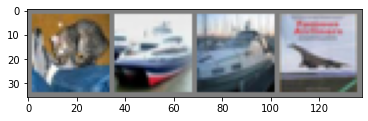

GroundTruth:    cat  ship  ship plane


In [23]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [24]:
# Let’s load back in our saved model

net = MyNet()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [25]:
# Let us see what the neural network thinks these examples above are

outputs = net(images)
outputs

tensor([[ 0.1022, -2.0548,  1.2628,  1.5284, -0.6343,  0.2351,  0.1090, -0.7829,
          0.1782, -1.8426],
        [ 5.9501,  6.5649, -1.2271, -3.9855, -3.1814, -5.2015, -4.9254, -2.4495,
          4.8837,  4.5311],
        [ 2.5801,  3.3837, -0.4820, -1.9409, -1.5686, -2.8354, -2.5442, -1.5169,
          2.9239,  2.0980],
        [ 5.7825,  0.3724,  1.3130, -2.4857,  0.2071, -3.7243, -4.5106, -0.6368,
          3.8801,  1.2486]], grad_fn=<AddmmBackward>)

In [26]:
outputs.shape

torch.Size([4, 10])

The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the highest energy:

In [27]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car   car plane


In [28]:
# Let us look at how the network performs on the whole dataset.

correct = 0
total = 0

# Since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Calculate outputs by running images through the network
        outputs = net(images)
        # The class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


That looks way better than chance, which is 10% accuracy (i.e. randomly picking a class out of 10 classes). Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did not perform well:

In [29]:
# Prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# Again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # Collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# Print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 67.9 %
Accuracy for class car   is: 69.9 %
Accuracy for class bird  is: 29.1 %
Accuracy for class cat   is: 32.3 %
Accuracy for class deer  is: 40.3 %
Accuracy for class dog   is: 53.2 %
Accuracy for class frog  is: 65.1 %
Accuracy for class horse is: 73.8 %
Accuracy for class ship  is: 57.2 %
Accuracy for class truck is: 64.5 %


## Training on GPU

Just like how you transfer a Tensor onto the GPU, you transfer the neural net onto the GPU.

Let’s first define our device as the first visible cuda device if we have CUDA available:

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [31]:
net.to(device)

MyNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [32]:
# Remember that you will have to send the inputs and targets at every step to the GPU too:

inputs, labels = data[0].to(device), data[1].to(device)

In [33]:
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')    

Tesla P100-PCIE-16GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [34]:
torch.cuda.empty_cache()